# Setup

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10,6]

train_csv = pd.read_csv('train.csv')
valid_csv = pd.read_csv('dev.csv')

# Preliminary Feature Models (not using Review Contents)
Let's try to establish a baseline model which doesn't rely heavily on the review data, since text data requires some fairly heavy data processing.

### Data Processing:
- User review count
- Restaurant review count
- Days since first user review
- Days since first restaurant review
- Review word count
- Review letter count
- Review capitalization count
- Review punctuation count
- Review rating (provided in base dataset)

To avoid leakage, we have to do the *historical* review counts.

In [2]:
def preliminary_feature(data):
    data['user_review_count'] = data.sort_values(['user_id','date']).groupby('user_id')['ex_id'].cumcount()
    data['user_average_rating'] = data.sort_values(['user_id', 'date']).groupby('user_id')['rating'].cumsum() \
                                  / (data['user_review_count'] + 1)
    data['restaurant_review_count'] = data.sort_values(['prod_id', 'date']).groupby('prod_id')['ex_id'].cumcount()
    data['restaurant_average_rating'] = data.sort_values(['prod_id', 'date']).groupby('prod_id')['rating'].cumsum() \
                                        / (data['restaurant_review_count'] + 1)
    data['wordcount'] = data['review'].str.count(" ")
    first_user_review = data.groupby('user_id')['date'].min()
    data['days_since_first_user'] = (pd.to_datetime(data.set_index('user_id')['date']) \
                                     - pd.to_datetime(first_user_review))\
                                    .dt.days.reset_index(drop=True)
    first_restaurant_review = data.groupby('prod_id')['date'].min()
    data['days_since_first_restaurant'] = (pd.to_datetime(data.set_index('prod_id')['date']) \
                                           - pd.to_datetime(first_restaurant_review)) \
                                          .dt.days.reset_index(drop=True)
    data['punctuation_count'] = data['review'].str.count('[,;:!.]')
    data['capitalization_count'] = data['review'].str.count('[A-Z]+')
    data['letter_count'] = data['review'].str.len()
    
    return data

In [3]:
train = preliminary_feature(train_csv)
valid = preliminary_feature(valid_csv)

In [4]:
print(train.columns)

Index(['ex_id', 'user_id', 'prod_id', 'rating', 'label', 'date', 'review',
       'user_review_count', 'user_average_rating', 'restaurant_review_count',
       'restaurant_average_rating', 'wordcount', 'days_since_first_user',
       'days_since_first_restaurant', 'punctuation_count',
       'capitalization_count', 'letter_count'],
      dtype='object')


### Models Trained: 

- Logistic Regression
- XGBoost
- XGBoost with adjustment for class imbalance

In [5]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [6]:
train_features = ['rating', 'user_review_count', 'user_average_rating', 'restaurant_review_count', 
                  'restaurant_average_rating',
                  'punctuation_count', 'wordcount', 'capitalization_count', 'letter_count',
                  'days_since_first_user', 'days_since_first_restaurant']

In [7]:
X_train = train[train_features]
y_train = train['label']

lr = LogisticRegression(max_iter = 800)
lr.fit(X_train, y_train)

tree = XGBClassifier(random_state=42)
tree.fit(X_train, y_train)

tree_balanced = XGBClassifier(scale_pos_weight= (len(y_train)-y_train.sum()) / y_train.sum(), random_state=42)
tree_balanced.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=8.716642782447035, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [8]:
train['pred_lr'] = lr.predict_proba(train[train_features])[:,1]
train['pred_tree'] = tree.predict_proba(train[train_features])[:,1]
train['pred_tree_balanced'] = tree_balanced.predict_proba(train[train_features])[:,1]

In [9]:
X_valid = valid[train_features]
y_valid = valid['label']

In [10]:
valid['pred_lr'] = lr.predict_proba(valid[train_features])[:,1]
valid['pred_tree'] = tree.predict_proba(valid[train_features])[:,1]
valid['pred_tree_balanced'] = tree_balanced.predict_proba(valid[train_features])[:,1]

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(pred, y, label, title=None):
    precision, recall, _ = precision_recall_curve(y, pred)
    aps = average_precision_score(y_true=y, y_score=pred)
    
    plt.step(recall, precision, alpha=0.2,
             where='post',
             label='{}: Average Precision = {:0.3f}'.format(label, aps))
    plt.fill_between(recall, precision, step='post', alpha=0.2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if title is None:
        title = 'Precision-Recall Curve'
    plt.title(title)
    plt.legend(loc="lower right")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

### Train set performance

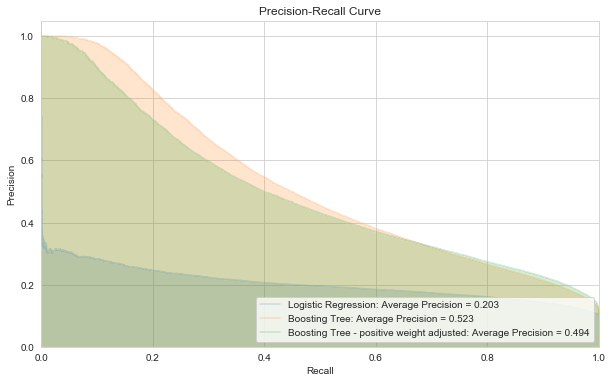

In [12]:
plot_pr(train['pred_lr'], train['label'], label='Logistic Regression')
plot_pr(train['pred_tree'], train['label'], label='Boosting Tree')
plot_pr(train['pred_tree_balanced'], train['label'], label='Boosting Tree - positive weight adjusted')

### Validation set performance

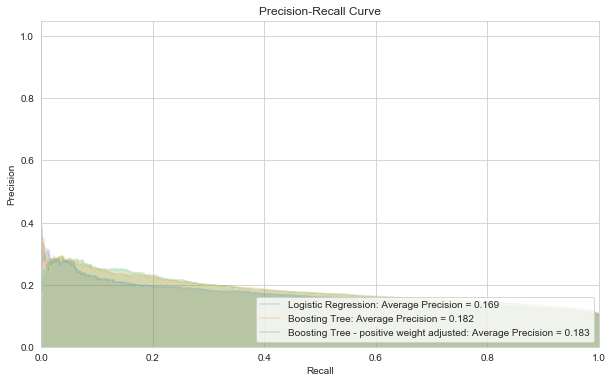

In [13]:
plot_pr(valid['pred_lr'], valid['label'], label='Logistic Regression')
plot_pr(valid['pred_tree'], valid['label'], label='Boosting Tree')
plot_pr(valid['pred_tree_balanced'], valid['label'], label='Boosting Tree - positive weight adjusted')

# Kitchen Sink Model

### Model: 
- XGBoost without adjustment for class imblance
- XGBoost with adjustment for class imblance

### Features:
12 + 32 = 44 features in total
- rating
- user_review_count
- user_average_rating
- restaurant_review_count
- restaurant_average_rating
- punctuation_count
- wordcount
- capitalization_count
- letter_count
- days_since_first_user
- days_since_first_restaurant
- pred_nb
- Word2Vec (vector size=32)

#### ↓ Prediction from MultinomialNB - TFIDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [15]:
cv = TfidfVectorizer(binary=False, ngram_range=(1,1), max_df=.5, min_df=.001)
text_data_train = cv.fit_transform(train['review'].tolist())
text_data_valid = cv.transform(valid['review'].tolist())

print(text_data_train.shape)
print(text_data_valid.shape)

(250874, 4701)
(35918, 4701)


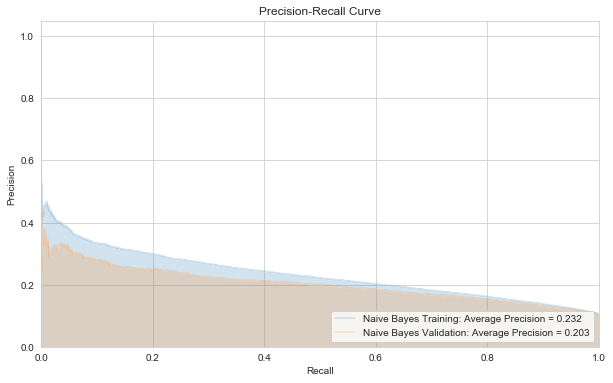

In [16]:
nb = MultinomialNB()
nb.fit(text_data_train, train['label'])

train['pred_nb'] = nb.predict_proba(text_data_train)[:,1]
valid['pred_nb'] = nb.predict_proba(text_data_valid)[:,1]

plot_pr(train['pred_nb'], train['label'], label='Naive Bayes Training')
plot_pr(valid['pred_nb'], valid['label'], label='Naive Bayes Validation')

#### ↓ Word2Vec using Gensim

In [17]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [18]:
documents_train = [TaggedDocument(doc, [i]) for i, doc in enumerate(train['review'].str.split(" "))]

In [19]:
d2v = Doc2Vec(documents_train, vector_size=32, window=2, min_count=100)

In [20]:
d2v_df_train = train['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_train.columns = ['d2v_' + str(x) for x in d2v_df_train.columns]

In [21]:
d2v_df_valid = valid['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_valid.columns = ['d2v_' + str(x) for x in d2v_df_valid.columns]

In [22]:
d2v_df_valid.head()

,d2v_0,d2v_1,d2v_2,d2v_3,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,...,d2v_22,d2v_23,d2v_24,d2v_25,d2v_26,d2v_27,d2v_28,d2v_29,d2v_30,d2v_31
0,0.095857,0.086437,0.053774,0.002667,0.168965,-0.183408,0.170865,-0.132025,0.159837,-0.112188,...,0.067975,-0.028683,0.267878,0.203453,-0.139906,-0.152146,0.242097,-0.009165,-0.104818,0.091923
1,0.259672,0.105996,-0.001518,0.018584,0.377914,-0.114495,0.368606,0.116079,0.230028,-0.059018,...,-0.132999,-0.070707,-0.181886,0.100273,-0.188816,0.117367,0.009860,0.056514,-0.208379,-0.086389
2,0.116748,-0.112548,0.165008,-0.395922,0.005925,-0.088814,0.268427,-0.031337,0.283520,0.129472,...,0.013062,-0.130232,0.448081,0.331567,-0.368775,-0.350052,0.198955,-0.165243,0.263681,0.367452
3,-0.082020,-0.046512,-0.067854,-0.226716,-0.093122,0.084252,0.298381,0.204708,0.106926,-0.176243,...,0.172718,-0.108044,0.217480,0.157327,-0.159412,-0.038488,0.364080,-0.020637,-0.210579,0.136532
4,0.050337,0.095867,-0.127850,-0.055626,0.303726,-0.072199,0.332703,-0.172071,0.087959,-0.157276,...,0.031993,0.032350,0.256458,0.140317,-0.095299,0.013719,-0.086668,0.059063,-0.131471,0.050115


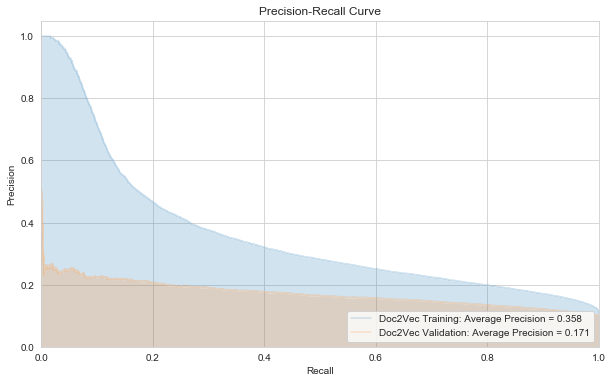

In [23]:
tree_d2v = XGBClassifier(random_state=42)
tree_d2v.fit(d2v_df_train, train['label'])

train['pred_d2v'] = tree_d2v.predict_proba(d2v_df_train)[:,1]
valid['pred_d2v'] = tree_d2v.predict_proba(d2v_df_valid)[:,1]

plot_pr(train['pred_d2v'], train['label'], label='Doc2Vec Training')
plot_pr(valid['pred_d2v'], valid['label'], label='Doc2Vec Validation')

#### ↓ Putting everything together

In [24]:
everything_train = pd.concat([train, d2v_df_train], axis=1)
everything_valid = pd.concat([valid, d2v_df_valid], axis=1)
everything_features = train_features + ['pred_nb'] + d2v_df_train.columns.tolist()
everything_features

['rating',
 'user_review_count',
 'user_average_rating',
 'restaurant_review_count',
 'restaurant_average_rating',
 'punctuation_count',
 'wordcount',
 'capitalization_count',
 'letter_count',
 'days_since_first_user',
 'days_since_first_restaurant',
 'pred_nb',
 'd2v_0',
 'd2v_1',
 'd2v_2',
 'd2v_3',
 'd2v_4',
 'd2v_5',
 'd2v_6',
 'd2v_7',
 'd2v_8',
 'd2v_9',
 'd2v_10',
 'd2v_11',
 'd2v_12',
 'd2v_13',
 'd2v_14',
 'd2v_15',
 'd2v_16',
 'd2v_17',
 'd2v_18',
 'd2v_19',
 'd2v_20',
 'd2v_21',
 'd2v_22',
 'd2v_23',
 'd2v_24',
 'd2v_25',
 'd2v_26',
 'd2v_27',
 'd2v_28',
 'd2v_29',
 'd2v_30',
 'd2v_31']

In [25]:
y_train = train['label']
pos_ratio = (len(y_train)-y_train.sum()) / y_train.sum()

everything_model = XGBClassifier(scale_pos_weight=pos_ratio, max_depth=4, reg_alpha=5, reg_lambda=30, random_state=42)
everything_model.fit(everything_train[everything_features], y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=5,
              reg_lambda=30, scale_pos_weight=8.716642782447035, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

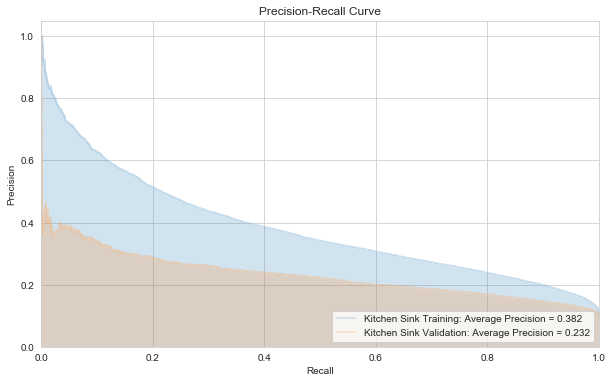

In [26]:
train['pred_everything'] = everything_model.predict_proba(everything_train[everything_features])[:,1]
valid['pred_everything'] = everything_model.predict_proba(everything_valid[everything_features])[:,1]

plot_pr(train['pred_everything'], train['label'], label='Kitchen Sink Training')
plot_pr(valid['pred_everything'], valid['label'], label='Kitchen Sink Validation')

In [27]:
importance = pd.DataFrame(columns = everything_features)
pd.DataFrame({'feature_name': everything_features, 'importance': everything_model.feature_importances_})\
.sort_values('importance', ascending=False)

,feature_name,importance
1,user_review_count,0.327754
11,pred_nb,0.175724
6,wordcount,0.067276
8,letter_count,0.043678
2,user_average_rating,0.040719
7,capitalization_count,0.036935
0,rating,0.023477
5,punctuation_count,0.022546
3,restaurant_review_count,0.021089
4,restaurant_average_rating,0.018333


#### (just to check) ↓ Without Gensim : slightly worse performance

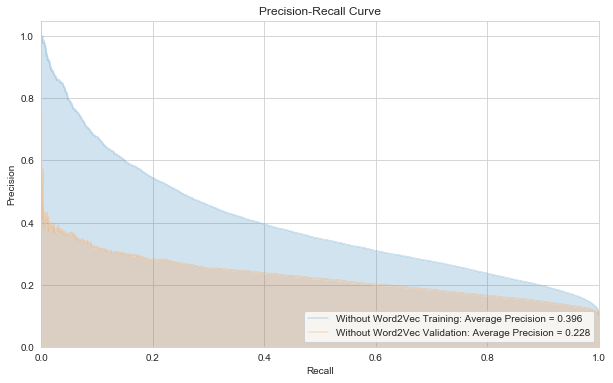

In [28]:
y_train = train['label']
pos_ratio = (len(y_train)-y_train.sum()) / y_train.sum()
nogensim_features = train_features + ['pred_nb']

nogensim_model = XGBClassifier(scale_pos_weight=pos_ratio, max_depth=4, reg_alpha=5, reg_lambda=30, random_state=42)
nogensim_model.fit(everything_train[nogensim_features], y_train)

train['pred_nogensim'] = nogensim_model.predict_proba(everything_train[nogensim_features])[:,1]
valid['pred_nogensim'] = nogensim_model.predict_proba(everything_valid[nogensim_features])[:,1]

plot_pr(train['pred_nogensim'], train['label'], label='Without Word2Vec Training')
plot_pr(valid['pred_nogensim'], valid['label'], label='Without Word2Vec Validation')

#### ↓ Adding user_id, prod_id

In [29]:
add_id_features = ['user_id', 'prod_id', 'rating', 'user_review_count', 'user_average_rating', 'restaurant_review_count', 
                  'restaurant_average_rating',
                  'punctuation_count', 'wordcount', 'capitalization_count', 'letter_count',
                  'days_since_first_user', 'days_since_first_restaurant']

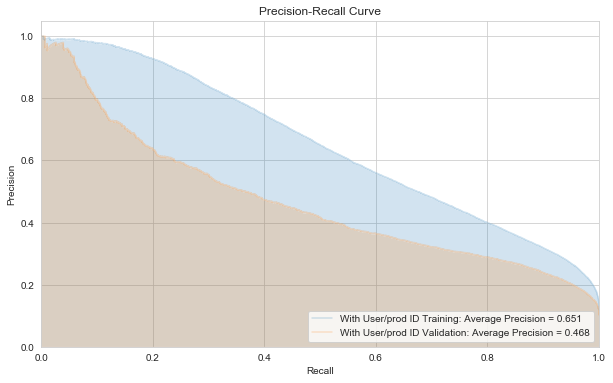

In [43]:
y_train = train['label']
pos_ratio = (len(y_train)-y_train.sum()) / y_train.sum()
id_features = add_id_features + ['pred_nb'] + d2v_df_train.columns.tolist()

# max_depth=7, reg_alpha=10, reg_labmda=5, train 0.837 / valid 0.529
# max_depth=4, reg_alpha=10, reg_labmda=5, train 0.561 / valid 0.418
id_model = XGBClassifier(scale_pos_weight=pos_ratio, max_depth=5, reg_alpha=10, reg_lambda=5, random_state=42)
id_model.fit(everything_train[id_features], y_train)

train['pred_id'] = id_model.predict_proba(everything_train[id_features])[:,1]
valid['pred_id'] = id_model.predict_proba(everything_valid[id_features])[:,1]

plot_pr(train['pred_id'], train['label'], label='With User/prod ID Training')
plot_pr(valid['pred_id'], valid['label'], label='With User/prod ID Validation')

In [31]:
pd.DataFrame({'feature_name': id_features, 'importance': id_model.feature_importances_})\
.sort_values('importance', ascending=False)

,feature_name,importance
3,user_review_count,0.468176
13,pred_nb,0.117977
0,user_id,0.045829
9,capitalization_count,0.029699
8,wordcount,0.029082
4,user_average_rating,0.028883
1,prod_id,0.025078
2,rating,0.021948
12,days_since_first_restaurant,0.017337
10,letter_count,0.016604


### ↓ previously spammed or not

In [72]:
from collections import Counter
spammer = set(train[train.label==1].user_id)
nonspammer = set(train[train.label==0].user_id)
print("number of ppl spam in training:", len(spammer))
print("number of ppl not spam in training:", len(nonspammer))
print("number of ppl spam n not spam:", len(spammer.intersection(nonspammer)))
print("prop. of spammers who make fake review only:", round((len(spammer)-len(spammer.intersection(nonspammer))) / len(spammer), 2))

number of ppl spam in training: 21006
number of ppl not spam in training: 105074
number of ppl spam n not spam: 401
prop. of spammers who make fake review only: 0.98


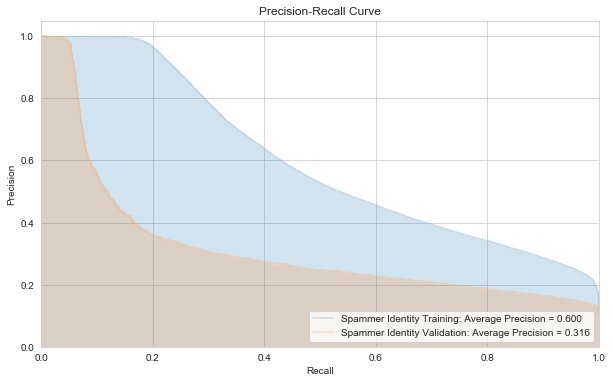

In [103]:
everything_train['spammed'] = train.sort_values(['user_id','date']).groupby('user_id')['label'].cumsum() > 1
everything_valid['spammed'] = valid.sort_values(['user_id','date']).groupby('user_id')['label'].cumsum() > 1

spam_features = ['spammed', 'rating', 'user_review_count', 'user_average_rating', 'restaurant_review_count', 
                 'restaurant_average_rating',
                 'punctuation_count', 'wordcount', 'capitalization_count', 'letter_count',
                 'days_since_first_user', 'days_since_first_restaurant']

y_train = train['label']
pos_ratio = (len(y_train)-y_train.sum()) / y_train.sum()
spammer_features = spam_features + ['pred_nb'] + d2v_df_train.columns.tolist()

spammer_model = XGBClassifier(scale_pos_weight=pos_ratio, max_depth=4, reg_alpha=10, reg_lambda=5, random_state=42)
spammer_model.fit(everything_train[spammer_features], y_train)

train['pred_id'] = spammer_model.predict_proba(everything_train[spammer_features])[:,1]
valid['pred_id'] = spammer_model.predict_proba(everything_valid[spammer_features])[:,1]

plot_pr(train['pred_id'], train['label'], label='Spammer Identity Training')
plot_pr(valid['pred_id'], valid['label'], label='Spammer Identity Validation')

### Test Set

In [32]:
# load test set and apply preliminary_feature
test_csv = pd.read_csv('test_no_label.csv').sort_values('ex_id')
test = preliminary_feature(test_csv)
test.columns

Index(['ex_id', 'user_id', 'prod_id', 'rating', 'label', 'date', 'review',
       'user_review_count', 'user_average_rating', 'restaurant_review_count',
       'restaurant_average_rating', 'wordcount', 'days_since_first_user',
       'days_since_first_restaurant', 'punctuation_count',
       'capitalization_count', 'letter_count'],
      dtype='object')

In [33]:
# MNB prediction on test
text_data_test = cv.transform(test['review'].tolist())
test['pred_nb'] = nb.predict_proba(text_data_test)[:,1]

In [34]:
# Word2Vec using Gensim
d2v_df_test = test['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_test.columns = ['d2v_' + str(x) for x in d2v_df_test.columns]

In [35]:
everything_test = pd.concat([test, d2v_df_test], axis=1)
predictions = everything_model.predict(everything_test[everything_features], output_margin=True)

In [36]:
pd.DataFrame(predictions).to_csv('predictions.csv', index=False, header=False)

In [38]:
pd.DataFrame(predictions)

,0
0,-0.147486
1,0.396430
2,0.980045
3,0.650749
4,0.580224
...,...
72160,-2.048587
72161,0.452267
72162,2.226233
72163,1.800751
